# Bidirectional Dynamic Seq2Seq

Encoder is bidirectional now. It feeds previously generated tokens as inputs during training, instead of target sequence.

Based on the repo https://github.com/ematvey/tensorflow-seq2seq-tutorials, some experience are noted:
* Replacing projection (one-hot encoding followed by linear layer) with embedding (indexing weights of linear layer directly) is more efficient.
* When decoding, feeding previously generated tokens as inputs adds robustness to model's errors. Nevertheless, feeding ground truth speeds up training. That is to say best practice is to mix both randomly while training.

In [1]:
import numpy as np

import sys
sys.path.append("tensorflow-seq2seq-tutorials")
import helpers

import tensorflow as tf
print("Tensorflow version: {}".format(tf.__version__))

Tensorflow version: 1.11.0


In [2]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [3]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units * 2

In [4]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name="encoder_inputs")
encoder_inputs_length = tf.placeholder(shape=(None,), dtype=tf.int32, name="encoder_inputs_length")

decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name="decoder_targets")

We feed data via `decoder_inputs` to understand how it works in previous. Here we implement decoder with `tf.nn.raw_rnn` and construct `decoder_inputs` step by step.

# Model

## Embeddings

In [5]:
embeddings = tf.get_variable("embeddings", dtype=tf.float32, \
                             shape=[vocab_size, input_embedding_size], \
                             initializer=tf.random_uniform_initializer(-1.0, 1.0))

encoder_inputs_embeded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

## Encoder

Here we replace un-directional `tf.nn.dynamic_rnn` with directional `tf.nn.bidirectional_dynamic_rnn` as the encoder.

In [6]:
from tensorflow.contrib.rnn import LSTMCell, LSTMStateTuple

In [7]:
encoder_cell = LSTMCell(encoder_hidden_units)

In [8]:
((encoder_fw_outputs, encoder_bw_outputs), (encoder_fw_final_state, encoder_bw_final_state)) = \
    tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell, \
                                    cell_bw=encoder_cell, \
                                    inputs=encoder_inputs_embeded, \
                                    sequence_length=encoder_inputs_length, \
                                    dtype=tf.float32, time_major=True)

In [9]:
encoder_fw_outputs

<tf.Tensor 'bidirectional_rnn/fw/fw/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 20) dtype=float32>

In [10]:
encoder_bw_outputs

<tf.Tensor 'ReverseSequence:0' shape=(?, ?, 20) dtype=float32>

In [11]:
encoder_fw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_4:0' shape=(?, 20) dtype=float32>)

In [12]:
encoder_bw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_3:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_4:0' shape=(?, 20) dtype=float32>)

We have to concatenate forward and backward outputs and states. In the case we won't ignore outputs, they are useful for `attention` mechanism.

In [13]:
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)

encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)

## Decoder

In [14]:
decoder_cell = LSTMCell(decoder_hidden_units)

In [15]:
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

Time and batch dimenions are dynamic. Next we decided how far to run the decoder, the stopping criteria are:
* Stop after specified number of unrolling steps.
* Stop after model produced token.

The choice will likely be time-dependent. In legacy `translate` tutorial, the decoder unrolls for `len(encoder_input) + 10` to allow for possibly longer translated sequence. Here we demo a toy copy task so that we unroll decoder for `len(encoder_input) + 2` to allow some room to make minstakes over `2` additional steps.

In [16]:
# 3 = 2 (additional steps) + 1 (leading <EOS> token)
decoder_lengths = encoder_inputs_length + 3

## Output projection

```text
output(t) -> output projection(t) -> prediction(t) (argmax) -> input embedding(t+1) -> input(t+1)
```

We used `tf.contrib.layers.linear` layer to initialize weights and biases and apply operations for us. Here we need to specify parameters `W` and `b` of the output layer in global scope, and apply them at every step of the decoder.

In [17]:
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32)
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

## Decoder via `tf.nn.raw_rnn`

`tf.nn.dynamic_rnn` allows for easy RNN construction, but it is limited.

For example, a way to increase robustness of the model is to feed as decoder input tokens generated previously, instead of shifted true sequence.

![](./tensorflow-seq2seq-tutorials/pictures/2-seq2seq-feed-previous.png)

refer to http://www.wildml.com/2016/04/deep-learning-for-chatbots-part-1-introduction/.

In [18]:
assert EOS == 1 and PAD == 0

eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')

eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

The standard `tf.nn.dynamic_rnn` requires all inputs `(t, ..., t+n)` be passed as a single tensor. The `dynamic` means the fact that `n` can change from batch to batch.

Now, what if we want to implement more complex mechanic like we want decoder to receive previously generated token as the input at every timestamp (instead of lagged target sequence)? Or when we want to implement a soft attention mechanism where at every timestamp we add additional fixed-length representation, derived from query produced by previous step's hidden state? We can use `tf.nn.raw_rnn` to solve these.

Main part of specifying `tf.nn.raw_rnn` is `loop transition function`, defining input of step `t` given outputs and state of step `t-1`.

`loop transition function` is called `before` RNNCell to prepare its inputs and states, and maps as below:
```text
(time, previous_cell_output, previous_cell_state, previous_loop_state) 
-> (elements_finished, input, cell_state, output, loop_state)
```

Everything is a Tensor except for initial call at time=0 where everything is `None` (except `time`).

Loop transition function was called at two conditions:
1. Initial call at time=0 to provide cell_state and input to RNN.
2. Transition call for all following timestamps where you define transition between two adjacent steps.

Loop initial state is function of only `encoder_final_state` and `embeddings`.

In [19]:
def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)  # all False at the initial step
    initial_input = eos_step_embedded
    initial_cell_state = encoder_final_state
    initial_cell_output = None
    initial_loop_state = None  # we don't need to pass any additional information
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)

Define transition function that previously generated token is passed as next input.

In [20]:
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):

    def get_next_input():
        output_logits = tf.add(tf.matmul(previous_output, W), b)
        prediction = tf.argmax(output_logits, axis=1)
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    
    elements_finished = (time >= decoder_lengths) # this operation produces boolean tensor of [batch_size]
                                                  # defining if corresponding sequence has ended

    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished, 
            input,
            state,
            output,
            loop_state)

Combine initializer and transition functions to create raw_rnn.

All operations above are defined with TF's control flow and reduction ops, here we check whether state is `None` to determine if it is an initializer call or transition call.

In [21]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)

decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [22]:
decoder_outputs

<tf.Tensor 'TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 40) dtype=float32>

In order to do the output projection, we have to temporarily flatten decoder_outputs from `[max_steps, batch_size, hidden_dim]` to `[max_step*batch_size, hidden_dim]` (`tf.matmul`).

In [23]:
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))

In [37]:
decoder_prediction = tf.argmax(decoder_logits, 2)

## Optimizer

RNN projection layer map onto `[max_time, batch_size, vocab_size]`, and `vocab_size` of the shape is static, while `max_time` and `batch_size` are dynamic.

In [25]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(\
        labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),\
        logits=decoder_logits)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [26]:
sess.run(tf.global_variables_initializer())

# Training on the toy task

Consider the copy task - given the `random` sequence of integers from a vocabulary, learn to memorize and reproduce input sequence. Random sequence is generated in random, unlike natural language, it don't contain any structure.

## Data preparation

In [27]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8, vocab_lower=2, vocab_upper=10, batch_size=batch_size)

print('data in batch: ')
for seq in next(batches)[:10]:
    print(seq)

data in batch: 
[8, 4, 2, 6]
[2, 4, 5, 3, 2]
[5, 8, 5, 8, 5]
[2, 2, 3, 8]
[9, 9, 3, 7]
[6, 6, 3, 4, 4, 6]
[2, 3, 6, 7, 7, 6]
[8, 6, 4, 9, 7, 5, 5]
[4, 4, 6, 5]
[4, 2, 7, 5, 4, 3, 8, 8]


In [33]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

## Training

In [34]:
loss_history = []

In [38]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_history.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.296715497970581
  sample 1:
    input     > [8 4 4 6 6 0 0 0]
    predicted > [4 2 0 0 0 1 0 1 0 0 0]
  sample 2:
    input     > [9 4 9 3 3 7 0 0]
    predicted > [4 4 6 4 6 2 6 2 9 0 0]
  sample 3:
    input     > [3 6 5 4 4 0 0 0]
    predicted > [7 1 7 1 7 1 7 8 0 0 0]

batch 1000
  minibatch loss: 0.5229266881942749
  sample 1:
    input     > [8 3 2 0 0 0 0 0]
    predicted > [8 3 2 1 0 0 0 0 0 0 0]
  sample 2:
    input     > [4 8 8 5 0 0 0 0]
    predicted > [4 8 8 5 1 0 0 0 0 0 0]
  sample 3:
    input     > [8 2 5 4 0 0 0 0]
    predicted > [8 2 5 4 1 0 0 0 0 0 0]

batch 2000
  minibatch loss: 0.23747214674949646
  sample 1:
    input     > [5 4 2 9 0 0 0 0]
    predicted > [5 4 2 9 1 0 0 0 0 0 0]
  sample 2:
    input     > [6 8 3 4 8 6 0 0]
    predicted > [6 8 3 4 8 6 1 0 0 0 0]
  sample 3:
    input     > [9 2 4 4 0 0 0 0]
    predicted > [9 2 4 4 1 0 0 0 0 0 0]

batch 3000
  minibatch loss: 0.15095090866088867
  sample 1:
    input     > [5 4 

loss:0.150731


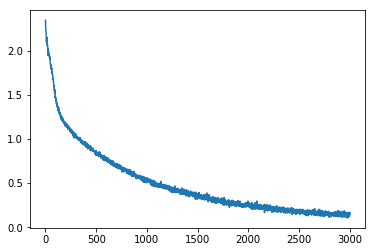

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_history)
print("loss:{:4f}".format(loss_history[-1]))